In [ ]:
#%load_ext autoreload
#%autoreload 2

<a name="top"></a>
# <center>Pegasus WMS Tutorial and Templates</center>

## Abstract

- This Jupyter Notebook tool provides an introductory  tutorial and template scripts for running Pegasus WMS workflows on Ghub.

- The Pegasus Workflow Management System (WMS) comprises software that automates and manages the execution of computational workflow jobs, including staging the jobs, distributing the work, submitting the jobs for execution, as well as handling data flow dependencies and overcoming job failures.

- This tool is modeled after the Pegasus Tutorial tool by d k.


## Overview

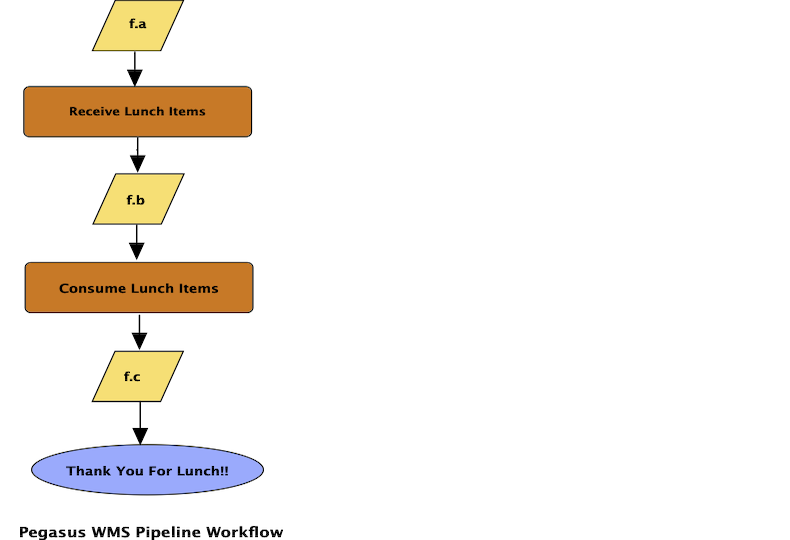

This tool provides Pegasus WMS pipeline workflow templates, which associate two simple workflow jobs to create a "Hello World" demonstration of Pegasus using an abstract YAML file and a cluster submission. These workflow jobs are executed on the University at Buffalo (UB)'s Center for Computational Research (CCR) high-performance compute cluster, UB-HPC, using Pegasus and submit!

This tool provides templates for workflow jobs written in the `Bash`, `C`, `CPP`, `Fortran`, `MATLAB`, `Python`, and `R` programming languages. Each programming language requires a different template because the scripts to launch the `Bash`, `Python`, and `R` scripts, and the scripts to build and launch the binary executables for the `C`, `CPP`, `Fortran`, and `MATLAB` source codes, are different for each programming language. Select your template of choice and view the scripts and source code for the selected template in the `View the Selected Template's Scripts and Source Code` section. The scripts and source code provide a guideline for you to create your Pegasus WMS workflow tool on Ghub. See the `Create Your Pegasus WMS Workflow Tool` section for more information.

Give it a try! Select a template, enter a string of lunch items in the `Lunch Items` text box, and click the `Launch Workflow` button. After you click the `Launch Workflow` button, the string of lunch items is saved to the file `f.a`. Pegasus transfers the `f.a` file and the workflow jobs for the selected template from Ghub to UB-HPC. On UB-HPC, the first workflow job reads the `f.a` file and writes the received lunch items to the file `f.b`. When the first workflow job completes, the second workflow job reads the `f.b` file and writes a thank you greeting to the file `f.c`. When the second workflow job completes, Pegasus transfers the `f.c` file from UB-HPC to Ghub, and the thank you greeting, contained in the `f.c` file, is displayed in the `View Workflow Results` section. See the `Give It a Try` section to get started.

An advantage of the Pegasus WMS is for executing workflow jobs in parallel on UB-HPC. See the [CCR_Ghub_Demo](https://github.com/GhubGateway/CCR_Ghub_Demo) GitHub repository for a demonstration and template for executing Pegasus WMS workflow jobs in parallel on UB-HPC.


In [ ]:

import atexit
import getpass
import numpy as np
import os
import platform
import shutil
import sys
import re
import time

import ipywidgets as widgets
from IPython.display import display, HTML, Markdown, clear_output, Image, Javascript, IFrame

import hublib
#print (help(hublib))
import hublib.ui as ui
#print (help(ui))
import hublib.use
#print (help(hublib.use))

import functools
import ctypes as ct 

# Version of Pegasus
%use pegasus-5.0.1

np.set_printoptions(threshold=np.inf) 


In [ ]:
# Setup paths to executables
scriptpath = os.path.realpath(" ")
        
# Get the parent dirs
self_tooldir = os.path.dirname(scriptpath)

# Setup path to python and bash scripts
self_bindir = os.path.join(self_tooldir, "bin")

# Add to this tool's bin directory to PYTHONPATH
sys.path.insert (1, self_bindir)

# Set up path to the current session directory
self_workingdir = os.getcwd()

# Set up path to the user's home directory
self_homedir = os.path.expanduser("~")

self_user = getpass.getuser()

import configuration as cfg
import build_wrapper #import BuildWrapper
import launch_wrapper #import LaunchWrapper

self_log_filepath = os.path.join(self_workingdir, 'ghubex1_log_file.txt')
self_log_backup_filepath = os.path.join(self_workingdir, 'ghubex1_log_backup_file.txt')

BORDER_STYLE = '1px solid black'

BOLD = '\033[1m'
SUCCESS = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
END = '\033[0m'

BUTTON_WIDTH = '410px'
BUTTON_HEIGHT = '30px'

DEFAULT_TEMPLATE = 'Python'
DEFAULT_LUNCH_ITEMS = 'Mango Avocado Salad'


In [ ]:
# Clean up: remove files from the data/results folder and the bin/__pycache__ folder
def exit_handler():
    
    for file in os.listdir(self_workingdir):
        
        if os.path.isfile(file):
            if file.endswith(".txt"):
                if file != "README.txt" and file != "LICENSE.txt" and file != "ghubex1_log_file.txt":
                    #print ("Deleting: %s\n" %file)
                    os.remove(file)
            elif file.endswith(".yml"):
                #print ("Deleting: %s\n" %file)
                os.remove(file)
            elif file.endswith(".stdout"):
                #print ("Deleting: %s\n" %file)
                os.remove(file)
            elif file.endswith(".stderr"):
                #print ("Deleting: %s\n" %file)
                os.remove(file)

atexit.register(exit_handler);   

In [ ]:
HTML('''
<style>.buttontextclass { color:black ; font-size:120%}</style>
''')

In [ ]:
# CSS styles

In [ ]:
HTML('''
<style>
div.cell {
font-size:15px;
line-height:140%
}
</style>
''')

In [ ]:
#https://api.jquery.com/ready/
HTML('''
<script>
    function scroll_to_top() {
        Jupyter.notebook.scroll_to_top();
    } 
    $( window ).on( "load", scroll_to_top() );
</script>
''')

In [ ]:
#https://stackoverflow.com/questions/36757301/disable-ipython-notebook-autoscrolling

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<a name="userguide"></a>
## User Guide [&#8607;](#top)


1. [**Give it a try**](#giveitatry)<br />
    
2. [**View the selected template's scripts and source code**](#view_scripts_and_source_code)<br />
    
3. [**Learn about software that powers this tool**](#learnaboutsoftware)<br />

4. [**Create your Pegasus WMS workflow tool**](#createyourworkflowtool)<br />


In [ ]:
def log_P_info():
    
    log_info ('')
    log_info ('Invoke_Script_Descr_P.value: %s' %Invoke_Script_Descr_P.value.decode())
    log_info ('Configuration_Script_Descr_P.value: %s' %Configuration_Script_Descr_P.value.decode())
    log_info ('Build_Wrapper_Script_Descr_P.value: %s' %Build_Wrapper_Script_Descr_P.value.decode())
    log_info ('Build_Script_Descr_P.value: %s' %Build_Script_Descr_P.value.decode())
    log_info ('Launch_Wrapper_Script_Descr_P.value: %s' %Launch_Wrapper_Script_Descr_P.value.decode())
    log_info ('Launch_Script_Descr_P.value: %s' %Launch_Script_Descr_P.value.decode())
    log_info ('WFJob1_Code_Descr_P.value: %s' %WFJob1_Code_Descr_P.value.decode())
    log_info ('WFJob2_Code_Descr_P.value: %s' %WFJob2_Code_Descr_P.value.decode())
    log_info ('Launch_Workflow_YAML_Descr_P.value: %s' %Launch_Workflow_YAML_Descr_P.value.decode())
    
    log_info ('Invoke_Script_Filepath_P.value: %s' %Invoke_Script_Filepath_P.value.decode())
    log_info ('Configuration_Script_Filepath_P.value: %s' %Configuration_Script_Filepath_P.value.decode())
    log_info ('Build_Wrapper_Script_Filepath_P.value: %s' %Build_Wrapper_Script_Filepath_P.value.decode())
    log_info ('Build_Script_Filepath_P.value: %s' %Build_Script_Filepath_P.value.decode())
    log_info ('Launch_Wrapper_Script_Filepath_P.value: %s' %Launch_Wrapper_Script_Filepath_P.value.decode())
    log_info ('Launch_Script_Filepath_P.value: %s' %Launch_Script_Filepath_P.value.decode())
    log_info ('WFJob1_Code_Filepath_P.value: %s' %WFJob1_Code_Filepath_P.value.decode())
    log_info ('WFJob2_Code_Filepath_P.value: %s' %WFJob2_Code_Filepath_P.value.decode())
    log_info ('Launch_Workflow_YAML_Filepath_P.value: %s' %Launch_Workflow_YAML_Filepath_P.value.decode())
    
    log_info('build_workflow_button.disabled: %s' %str(build_workflow_button.disabled)) 
    log_info('launch_workflow_button.disabled: %s' %str(launch_workflow_button.disabled))   
    log_info ('')


# Create pointers for button click arguments that vary depending on the selected template

Selected_Template = DEFAULT_TEMPLATE
Selected_Template_Index = cfg.TEMPLATE_LIST.index(Selected_Template)

Invoke_Script_Descr_P = ct.c_char_p(('Invoke Script').encode())
Configuration_Script_Descr_P = ct.c_char_p(('Configuration Script').encode())
Build_Wrapper_Script_Descr_P = ct.c_char_p(('Build Wrapper Script N/A').encode())
Build_Script_Descr_P = ct.c_char_p(('Build Script N/A').encode())
Launch_Wrapper_Script_Descr_P = ct.c_char_p(('Launch Wrapper Script').encode())
Launch_Script_Descr_P = ct.c_char_p(('%s Launch Script' %Selected_Template).encode())
WFJob1_Code_Descr_P = ct.c_char_p(('%s Workflow Job 1 %s' %(Selected_Template, cfg.CODE_TYPE_LIST[Selected_Template_Index])).encode())
WFJob2_Code_Descr_P = ct.c_char_p(('%s Workflow Job 2 %s' %(Selected_Template, cfg.CODE_TYPE_LIST[Selected_Template_Index])).encode())
Launch_Workflow_YAML_Descr_P = ct.c_char_p(('Launch Workflow YAML File').encode())

Invoke_Script_Filepath_P = ct.c_char_p(os.path.join(self_tooldir, 'middleware', 'invoke').encode())
Configuration_Script_Filepath_P = ct.c_char_p(os.path.join(self_tooldir, 'bin', 'configuration.py').encode())
Build_Wrapper_Script_Filepath_P = ct.c_char_p(os.path.join(self_tooldir, 'bin', 'build_wrapper.py').encode())
Build_Script_Filepath_P = ct.c_char_p(os.path.join(self_tooldir, 'remotebin', Selected_Template, '%s_Build.sh' %Selected_Template).encode())
Launch_Wrapper_Script_Filepath_P = ct.c_char_p(os.path.join(self_tooldir, 'bin', 'launch_wrapper.py').encode())
Launch_Script_Filepath_P = ct.c_char_p(os.path.join(self_tooldir, 'remotebin', Selected_Template, '%s_Launch.sh' %Selected_Template).encode())
WFJob1_Code_Filepath_P = ct.c_char_p(os.path.join(self_tooldir, 'bin', Selected_Template, cfg.CODE1_LIST[Selected_Template_Index]).encode())
WFJob2_Code_Filepath_P = ct.c_char_p(os.path.join(self_tooldir, 'bin', Selected_Template, cfg.CODE2_LIST[Selected_Template_Index]).encode())
Launch_Workflow_YAML_Filepath_P = ct.c_char_p(os.path.join(self_tooldir, 'launch_workflow.yml').encode())


In [ ]:
def show_file_header(template):
    
    display(HTML('<h3>Contents of file %s:</h3>' %template))
    
def show_download_button(download_button_output=None, filepath=None):
    
    with download_button_output:
        
        #print ('show_download_button filepath: ', filepath)
        # Download file from Ghub
        display(HTML('<h3>Download %s to Your Web Browser</h3>' %os.path.basename(filepath)))
        #print (os.path.relpath(self_log_filepath, self_tooldir))
        downloadTXTButton = ui.Download(os.path.relpath(filepath, self_tooldir),
            label = 'Download File', style='success', icon='fa-arrow-circle-down')
        display(downloadTXTButton)
    
def show_file_output(button, descr_p=None, filepath_p=None, file_output=None, download_button_output=None):

    log_info ('show_file_output...')
        
    log_info ('button: %s' %str(button))
    log_info ('descr_p: %s' %str(descr_p))
    descr = descr_p.value.decode()
    log_info ('descr: %s' %str(descr))
    log_info ('filepath_p: %s' %str(filepath_p))
    filepath = filepath_p.value.decode()
    log_info ('filepath: %s' %(filepath))
    
    if os.path.exists(filepath):

        if button.description == 'Show %s' %descr:

            button.description = 'Hide %s' %descr

            with file_output:
            
                show_file_header(filepath)

                #print("%s: \n\n" %filepath)
                f = open(filepath,'r')
                for line in f:
                    print(line.rstrip())
                f.close()

                if 'Invoke Script' not in descr:
                    show_download_button(download_button_output, filepath)
        else:

            button.description = 'Show %s' %descr
            file_output.clear_output()
            download_button_output.clear_output()
    else:
        log_error (file_output, '%s does not exist.' %filepath)


In [ ]:
def show_file_output_button(descr_p, filepath_p, disabled):
    button = widgets.Button(description='Show %s' %descr_p.value.decode(), disabled=disabled,\
        layout=widgets.Layout(width=BUTTON_WIDTH, height=BUTTON_HEIGHT),\
        style= {'button_color':'skyblue','font_weight':'bold'}).add_class('buttontextclass')
    file_output = widgets.Output(layout={'border': BORDER_STYLE})
    download_button_output = widgets.Output()
    button.on_click\
        (functools.partial(show_file_output, descr_p=descr_p, filepath_p=filepath_p, file_output=file_output, download_button_output=download_button_output))
    display (button)
    display (file_output)
    display (download_button_output)
    return button, file_output, download_button_output


<a name="giveitatry"></a>
## Give It a Try [&#8607;](#userguide)

<a name="select_template"></a>
### Select the Template for the Workflow Jobs [&#8607;](#userguide)

- See the `View the Selected Template's Scripts and Source Code` section to view the scripts and source code for the selected template.


In [ ]:
def launch_workflow_disabled():
    
    if cfg.BIN1_LIST[Selected_Template_Index] != None:
        
        binfiles = [cfg.BIN1_LIST[Selected_Template_Index], cfg.BIN2_LIST[Selected_Template_Index]]
        #print ('binfiles: ', binfiles)

        for i in range(len(binfiles)):

            binfile = binfiles[i]
            binfilepath = os.path.join(self_bindir, Selected_Template, binfile)
            if os.path.exists(binfilepath) == False:
                return True
        return False
    
    else:
        return False


In [ ]:
def template_list_dropdown_callback(change):
    
    #print ('change: ', change)
    
    #global Build_Wrapper
    #global Launch_Wrapper
    
    global Selected_Template
    global Selected_Template_Index
       
    if change['type'] == 'change' and change['name'] == 'value' and change['new'] != ' ' \
        and  template_list_dropdown.value != None:
        
        log_info ('template_list_dropdown_callback...')
        
        Selected_Template = template_list_dropdown.value
        log_info ('Selected_Template: %s' %Selected_Template)
        Selected_Template_Index = cfg.TEMPLATE_LIST.index(Selected_Template)
        log_info ('Selected_Template_Index: %d' %Selected_Template_Index)
        
       
        workflow_progress.clear_output()
        workflow_results.clear_output()
        build_wrapper_script_file_output.clear_output()
        build_wrapper_script_download_button_output.clear_output()
        build_script_file_output.clear_output()
        build_script_download_button_output.clear_output()
        launch_wrapper_script_file_output.clear_output()
        launch_wrapper_script_download_button_output.clear_output()
        launch_script_file_output.clear_output()
        launch_script_download_button_output.clear_output()
        wfjob1_code_file_output.clear_output()
        wfjob1_code_download_button_output.clear_output()
        wfjob2_code_file_output.clear_output()
        wfjob2_code_download_button_output.clear_output()
        launch_workflow_yaml_file_output.clear_output()
        show_launch_workflow_yaml_button.disabled = True
      
        if cfg.BIN1_LIST[Selected_Template_Index] != None:

            # If running the installed version of the notebook
            if os.path.islink(os.path.join(self_tooldir, 'README.md')):
                log_info ('Compiling %s binary executables is currently disabled.' %Selected_Template)
                build_workflow_button.disabled = True
            else:
                build_workflow_button.disabled = False
            show_build_wrapper_script_button.disabled = False
            show_build_script_button.disabled = False
            Build_Wrapper_Script_Descr_P.value = ('Build Wrapper Script').encode()
            Build_Script_Descr_P.value = ('%s Build Script' %Selected_Template).encode()
            launch_workflow_button.disabled = launch_workflow_disabled()
            
        else:
            
            build_workflow_button.disabled = True
            show_build_wrapper_script_button.disabled = True
            show_build_script_button.disabled = True
            Build_Wrapper_Script_Descr_P.value = ('Build Wrapper Script N/A').encode()
            Build_Script_Descr_P.value = ('Build Script N/A').encode()
            launch_workflow_button.disabled = False
            
        Launch_Script_Descr_P.value = ('%s Launch Script' %Selected_Template).encode()
        WFJob1_Code_Descr_P.value = ('%s Workflow Job 1 %s' %(Selected_Template, cfg.CODE_TYPE_LIST[Selected_Template_Index])).encode()
        WFJob2_Code_Descr_P.value = ('%s Workflow Job 2 %s' %(Selected_Template, cfg.CODE_TYPE_LIST[Selected_Template_Index])).encode()

        show_build_wrapper_script_button.description = 'Show %s' %Build_Wrapper_Script_Descr_P.value.decode()
        show_build_script_button.description = 'Show %s' %Build_Script_Descr_P.value.decode()
        show_launch_wrapper_script_button.description = 'Show Launch Wrapper Script'
        show_launch_script_button.description = 'Show %s' %Launch_Script_Descr_P.value.decode()
        show_wfjob1_code_button.description = 'Show %s' %WFJob1_Code_Descr_P.value.decode()
        show_wfjob2_code_button.description = 'Show %s' %WFJob2_Code_Descr_P.value.decode()
        show_launch_workflow_yaml_button.description = 'Show %s' %Launch_Workflow_YAML_Descr_P.value.decode()

        WFJob1_Code_Filepath_P.value = os.path.join(self_tooldir, 'bin', Selected_Template, cfg.CODE1_LIST[Selected_Template_Index]).encode()
        WFJob2_Code_Filepath_P.value = os.path.join(self_tooldir, 'bin', Selected_Template, cfg.CODE2_LIST[Selected_Template_Index]).encode()
        Build_Script_Filepath_P.value = os.path.join(self_tooldir, 'remotebin', Selected_Template, '%s_Build.sh' %Selected_Template).encode()
        Launch_Script_Filepath_P.value = os.path.join(self_tooldir, 'remotebin', Selected_Template, '%s_Launch.sh' %Selected_Template).encode()
        
        log_P_info()

DROPDOWN_WIDTH = '200px'
DROPDOWN_HEIGHT = '44px'
template_list_dropdown = widgets.Dropdown(
    name = 'Template',
    description = '<h4>Template:\xa0\xa0\xa0\xa0\xa0\xa0\xa0</h4>',
    value = cfg.TEMPLATE_LIST[Selected_Template_Index],
    options = cfg.TEMPLATE_LIST,
    style = {'description_width': '100px'},
    layout = widgets.Layout(width=DROPDOWN_WIDTH, height=DROPDOWN_HEIGHT)
)
template_list_dropdown.observe(template_list_dropdown_callback)

template_list_dropdown_output = widgets.Output(layout={'border': BORDER_STYLE})
display (template_list_dropdown_output)
with template_list_dropdown_output:
    display(template_list_dropdown)

<a name="enter_lunch_items"></a>
### Enter the Lunch Items [&#8607;](#userguide)


In [ ]:
TEXT_WIDTH = '500px'
TEXT_HEIGHT = '40px'
lunch_items_text_box = widgets.Text(
    name = "lunch_items",
    placeholder = 'Default: ' + DEFAULT_LUNCH_ITEMS,
    description = '<h4>Lunch Items:</h4>',
    units = '',
    style = {'description_width': '100px'},\
    layout=widgets.Layout(width=TEXT_WIDTH, height=TEXT_HEIGHT)#,
    #value = DEFAULT_LUNCH_ITEMS
)

lunch_items_output = widgets.Output(layout={'border': BORDER_STYLE})
display (lunch_items_output)
with lunch_items_output:
    display(lunch_items_text_box)


<a name="launch_workflow"></a>
### Launch  the Workflow [&#8607;](#userguide)

- Click the `Launch Workflow` button to launch the workflow for the selected template.  See the `Launch Scripts` section for more information.

- The `C`, `CPP`, `Fortran` and `MATLAB` templates require binary executables built on CCR to exist in the tool's bin directory. If the required binary executables are not found, the `Launch Workflow` button is disabled. See the `Build the Workflow Executables` section for more information.

- You will receive an email when the workflow completes.

- Results are displayed in the `View Workflow Results` section.

- If an error is encountered while running the workflow, the cause of the error will be written to the log output file, ghubex1_log_file.txt. See the `View Log Output` section for more information.


In [ ]:
# Run launch workflow

def launch_workflow_button_callback(p):
    
    # print (p) #Button   
    
    workflow_type = 'Launch'
    workflow_succeeded = False
    
    workflow_progress.clear_output()
    workflow_results.clear_output()
    
    disable_widgets()
        
    with workflow_progress:
        
        start_time = time.time()

        try:
            
            if launch_workflow_disabled() == False:
                
                workflow_results_filepath = os.path.join(self_workingdir, 'f.c')

                if os.path.exists(workflow_results_filepath):
                    os.remove(workflow_results_filepath)
                    
                # Remove any special characters from the lunch items string.
                # If the placeholder value is contained in the text box, len(lunch_items).rstrip() == 0
                lunch_items = re.sub(r"[^a-zA-Z0-9,-]+", ' ', str(lunch_items_text_box.value))[:100]
                if len(lunch_items.rstrip()) == 0:
                    log_info ('With special characters removed, the lunch items text box contains a zero length string. Resetting to the default: %s' \
                                %DEFAULT_LUNCH_ITEMS)
                    lunch_items = DEFAULT_LUNCH_ITEMS
                    lunch_items_text_box.value = lunch_items
                    
                # Note: Workflow execution time depends on the current UB CCR workload
                log_status (workflow_progress, '\nPegasus Launch Workflow in progress. This will take approximately 10 minutes...')

                wrapper = launch_wrapper.LaunchWrapper \
                    (Selected_Template_Index, self_user, lunch_items)
                #print ('launch wrapper: ', wrapper)
                returnCode = wrapper.run_workflow()
                show_launch_workflow_yaml_button.disabled = False
                
                log_status (workflow_progress, '\nWorkflow elapsed time: ' + str((time.time() - start_time)/60.0) + ' minutes\n')
                
                if returnCode == 0:

                    # Check if the results file was created and transferred from CCR 
                    # to determine if workflow completed successfully

                    if os.path.exists(workflow_results_filepath):

                        workflow_succeeded = True
                        log_status (workflow_progress, 'Workflow completed successfully\n')

                        with workflow_results:

                            print('\n')
                            f = open(workflow_results_filepath,'r')
                            for line in f:
                                log_success(workflow_results, line.rstrip())
                            f.close()
                            print('\n')

                    else:

                        workflow_succeeded = False
                        log_error (workflow_progress, '%s not generated by the workflow.\n' %workflow_results_filepath)
                        log_error (workflow_progress, 'Workflow did not complete successfully')

                        filepath = os.path.join(self_workingdir, 'pegasus.analysis')
                        if (os.path.exists(filepath)):
                            print('pegasus.analysis:\n')
                            f = open(filepath, 'r')
                            output = f.read()
                            f.close()
                            print (output)
                else:
                    
                    workflow_succeeded = False
                    log_error (workflow_progress, 'LaunchWrapper returned a nonzero return code: %d.' %returnCode)
                    
            else:
                workflow_succeeded = False
                log_error (workflow_progress, 'The %s template requires executables built on CCR to exist in the ./bin/%s directory.' %(Selected_Template, Selected_Template))
                log_error (workflow_progress, 'Click the Build Workflow Executables button to build the executables.')
 
        except Exception as e:
        
            workflow_succeeded = False
            log_error (workflow_progress, 'Workflow Exception: %s\n' %str(e))
        
        finish_workflow_processing(workflow_type, workflow_succeeded)

    enable_widgets()
            

launch_workflow_button = widgets.Button(description='Launch Workflow', disabled=False,\
    layout=widgets.Layout(width=BUTTON_WIDTH, height=BUTTON_HEIGHT),\
    style= {'button_color':'lawngreen','font_weight':'bold'}).add_class('buttontextclass')
launch_workflow_button.on_click (launch_workflow_button_callback)


In [ ]:
launch_workflow = widgets.Output(layout={'border': BORDER_STYLE})
display (launch_workflow)
with launch_workflow:
    display(launch_workflow_button)


### Workflow YAML File ↟

The Workflow YAML file is created or replaced when the Launch Workflow button is clicked. See the `Launch Scripts and Source Code` section for more information.


In [ ]:
show_launch_workflow_yaml_button, launch_workflow_yaml_file_output, launch_workflow_yaml_download_button_output = \
    show_file_output_button (Launch_Workflow_YAML_Descr_P, Launch_Workflow_YAML_Filepath_P, True)

<a name="build_workflow_executables"></a>
### Build the Workflow Executables [&#8607;](#userguide)

- Click the `Build Workflow Executables` button to build the binary executables for the `C`, `CPP`, `Fortran` and `MATLAB` templates.

- The returned binary executables are copied to the tool's bin directory.

- You will only need to click the `Build Workflow Executables` button when binary executables are required for new or updated source code files.

- The `Build Workflow Executables` button is disabled when this notebook is launched from the Ghub desktop. Otherwise, the `Build Workflow Executables` button is enabled when the `C`, `CPP`, `Fortran` or `MATLAB` template is selected.  See the `Build Scripts` section for more information.

- You will receive an email when the workflow completes.

- If an error is encountered while running the workflow, the cause of the error will be written to the log output file, ghubex1_log_file.txt. See the `View Log Output` section for more information.


In [ ]:
# Run build executables workflow

def build_executables_workflow_button_callback(p):
    
    # print (p) #Button
    
    workflow_type = 'Build'
    workflow_succeeded = False
        
    workflow_progress.clear_output()
    workflow_results.clear_output()
    
    disable_widgets()
        
    with workflow_progress:
        
        start_time = time.time()
        
        try:
            
            binfiles = [cfg.BIN1_LIST[Selected_Template_Index], cfg.BIN2_LIST[Selected_Template_Index]]
            #print ('binfiles: ', binfiles)
           
            for i in range(len(binfiles)):

                binfile = binfiles[i]
                binfilepath = os.path.join(self_bindir, Selected_Template, binfile)
                if os.path.exists(binfilepath):
                        #print ('removing %s.' %binfilepath)
                        os.remove(binfilepath)
                
            #Note: Workflow execution time depends on the current UB CCR workload.
            log_status (workflow_progress, '\nPegasus Build Workflow in progress. This will take approximately 10 minutes...')
            
            wrapper = build_wrapper.BuildWrapper \
                (Selected_Template_Index, self_user)
            #print ('build wrapper: ', wrapper)
            returnCode = wrapper.run_workflow()
            
            log_status (workflow_progress, '\nWorkflow elapsed time: ' + str((time.time() - start_time)/60.0) + ' [min]\n')
            
            if returnCode == 0:
            
                # Check if the results files were created and transferred from CCR 
                # to determine if workflow completed successfully

                workflow_completed_successfully = True
                for i in range(len(binfiles)):
                    binfile = binfiles[i]
                    binfilepath = os.path.join(self_bindir, Selected_Template, binfile)
                    if os.path.exists(binfile) == True:
                        log_status (workflow_progress, 'Moving %s to %s' %(binfile, binfilepath))
                        shutil.move(binfile, binfilepath)
                    else:
                        log_error (workflow_progress, '%s not generated by the workflow.' %binfile)
                        workflow_completed_successfully = False

                if workflow_completed_successfully:

                    workflow_succeeded = True
                    log_status (workflow_progress, '\nWorkflow completed successfully\n')

                else:

                    workflow_succeeded = False
                    log_error (workflow_progress, '\nWorkflow did not complete successfully')
 
                    filepath = os.path.join(self_workingdir, 'pegasus.analysis')
                    if (os.path.exists(filepath)):
                        print ('pegasus.analysis:\n')
                        f = open(filepath, 'r')
                        output = f.read()
                        f.close()
                        print (output)
                        os.remove(filepath)

            else:
                
                workflow_succeeded = False
                log_error (workflow_progress, '\nBuildWrapper returned a nonzero return code: %d.' %returnCode)
                    
        except Exception as e:
            
            workflow_succeeded = False
            log_error (workflow_progress, '\nWorkflow Exception: %s\n' %str(e))
            
        finish_workflow_processing(workflow_type, workflow_succeeded)
            
    enable_widgets()

# Abort
# Select Kernel Interrupt
#if self_tW.is_alive() == True:
   #self_tW.terminate()

# The default template is Bash, so this button is disabled by default
build_workflow_button = widgets.Button(description='Build Workflow Executables', disabled=True,\
    layout=widgets.Layout(width=BUTTON_WIDTH, height=BUTTON_HEIGHT),\
    style= {'button_color':'lawngreen','font_weight':'bold'}).add_class('buttontextclass')
build_workflow_button.on_click (build_executables_workflow_button_callback)


In [ ]:
build_workflow = widgets.Output(layout={'border': BORDER_STYLE})
display (build_workflow)
with build_workflow:
    display(build_workflow_button)

<a name="view_workflow_progress"></a>
### View Workflow Progress [&#8607;](#userguide)


In [ ]:
workflow_progress = widgets.Output(layout={'border': '1px solid black'})
display(workflow_progress)

<a name="view_workflow_results"></a>
### View Workflow Results [&#8607;](#userguide)


In [ ]:
workflow_results = widgets.Output(layout={'border': '1px solid black'})
display(workflow_results)

In [ ]:
def send_user_email(workflow_type, workflow_succeeded):

    email_subject = 'Ghub session #' + session_num + '.'
    
    if workflow_succeeded:
        email_text = 'Your ghubex1 %s workflow is complete!\r' %workflow_type
        email_text = email_text+'\rOutput files can be accessed on theghub.org in the following directory:'
        email_text = email_text+'\r' + str(self_workingdir)
    else:
        email_text = 'Your ghubex1 %s workflow failed.' %workflow_type
        email_text = email_text+'\rPlease check theghub.org for further information, in the directory:'
        email_text = email_text+'\r' + str(self_workingdir)        
        
    email_cmd = 'submit --progress silent mail2self -t "'+email_text+'" -s "'+email_subject+'"'
    
    # email debugging
    start_time = time.time()
    os.system(email_cmd)
    #print ('email elapsed time: ', str((time.time() - start_time)/60.0) + ' minutes\n')

In [ ]:
    
def finish_workflow_processing(workflow_type, workflow_succeeded):
    
    try:

        log_status (workflow_progress, 'Finish %s Workflow Processing...' %workflow_type)
        
        # workflow.yml is created by Wrapper.py
        #filepath = os.path.join(self_workingdir, 'workflow.yml')
        #if os.path.exists(filepath):
            #print ("Deleting: %s\n" %filepath)
            #os.remove(filepath)

        for file in os.listdir(self_workingdir):
            if os.path.isfile(file):
                
                if file[0] == ".":
                    if file != ".gitattributes":
                        #print ("Deleting: %s\n" %file)
                        os.remove(file)

                if file.endswith('.stdout'):
                    log_info ('\n%s:\n' %file)
                    f = open(file,'r')
                    for line in f:
                        log_info (line)
                    f.close()
                    os.remove(file)
                    
                if file.endswith('.stderr'):
                    log_info ('\n%s:\n' %file)
                    f = open(file,'r')
                    for line in f:
                        log_info (line)
                    f.close()
                    os.remove(file)
         
        filepath = os.path.join(self_workingdir, 'pegasus.analysis')
        if (os.path.exists(filepath)):
            filesize = os.path.getsize(filepath)
            log_info ('\npegasus.analysis filesize: ' + str(filesize))
            log_info ('pegasus.analysis:\n')
            f = open(filepath, 'r')
            output = f.read()
            f.close()
            log_info (output)
            os.remove(filepath)
        
        filepath = os.path.join(self_workingdir, "pegasusstatus.txt")
        if os.path.exists(filepath):
            #print ("Deleting: %s\n" %filepath)
            os.remove(filepath)

        filepath = os.path.join(self_workingdir, "pegasusjobstats.csv")
        if os.path.exists(filepath):
            #print ("Deleting: %s\n" %filepath)
            os.remove(filepath)

        filepath = os.path.join(self_workingdir, "pegasussummary-time.csv")
        if os.path.exists(filepath):
            #print ("Deleting: %s\n" %filepath)
            os.remove(filepath)

        filepath = os.path.join(self_workingdir, "pegasussummary.csv")
        if os.path.exists(filepath):
            #print ("Deleting: %s\n" %filepath)
            os.remove(filepath)

        # send email to user
        send_user_email(workflow_type, workflow_succeeded)
                
        log_status (workflow_progress, 'Done.')
        
    except Exception as e:
        log_error (workflow_progress, "EXCEPTION: %s\n" % str(e))

<a name="show_log_output"></a>
### View Log Output [&#8607;](#userguide)

- If an error is encountered while running this tool, the cause of the error will be written to the log output file, ghubex1_log_file.txt.

- Click the `Show Log Output` button to view the log output file.


In [ ]:
def show_log_output(change):
    
    if os.path.exists(self_log_filepath):
            
        if show_log_output_button.description == 'Show Log Output':
        
            show_log_output_button.description = 'Hide Log Output'
        
            with log_output:
            
                if os.path.exists(self_log_filepath):
                    print("%s: \n\n" %self_log_filepath)
                    f = open(self_log_filepath,'r')
                    for line in f:
                        print(line.rstrip())
                    f.close()
                else:
                    log_error (log_output, '%s does not exist ' %self_log_filepath + '. Please contact us.')
        else:
        
            show_log_output_button.description = 'Show Log Output'
            log_output.clear_output()
    else:
        log_error (log_output, '%s does not exist ' %self_log_filepath + '. Please contact us.')

show_log_output_button = widgets.Button(description="Show Log Output", disabled=False,\
    layout=widgets.Layout(width=BUTTON_WIDTH, height=BUTTON_HEIGHT),\
    style= {'button_color':'skyblue','font_weight':'bold'})

show_log_output_button.add_class("buttontextclass")
show_log_output_button.on_click(show_log_output)
display (show_log_output_button)

In [ ]:
log_output = widgets.Output(layout={'border': '1px solid black'})
display (log_output)

<a name="view_scripts_and_source_code"></a>
## View the Selected Template's Scripts and Source Code [&#8607;](#userguide)

- Click a button below to view the scripts and source code for the selected template. When a button is clicked, a Download button will also display to enable you to download the script or source code to your web browser.

<a name="show_invoke_script"></a>
### Invoke Script [&#8607;](#userguide)

The invoke script enables this tool, Ghub tool name ghubex1, to be launched on Ghub. See [Invoke scripts for Jupyter notebooks](https://theghub.org/kb/development/invoke-scripts-for-jupyter-notebooks) for more information. The invoke script directs this notebook to display in Appmode when this tool is launched. To see this notebook's code, while in Appmode mode click the Edit App button.

In [ ]:
show_invoke_script_button, invoke_script_file_output, invoke_script_download_button_output = \
    show_file_output_button (Invoke_Script_Descr_P, Invoke_Script_Filepath_P, False)

<a name="show_configuration_script"></a>
### Configuration Script [&#8607;](#userguide)

The configuation script defines the workflow jobs for the templates.


In [ ]:
show_configuration_script_button, configuration_script_file_output, configuration_script_download_button_output = \
    show_file_output_button (Configuration_Script_Descr_P, Configuration_Script_Filepath_P, False)

<a name="show_launch_scripts_and_source_code"></a>
### Launch Scripts[&#8607;](#userguide)

When the `Launch Workflow` button is clicked, the `Launch Wrapper` Python script's LaunchWrapper class is instantiated to plan and start a Pegasus workflow.

The Pegasus WMS consists of Pegasus and its workflow engine, HTCondor's directed acyclic graph (DAG) Manager (DAGMan).

Pegasus requires three catalogs and the workflow's job definitions to plan and start a workflow.

- The Site Catalog defines the site(s) where the workflow jobs are to be executed. On Ghub, the site catalog is preconfigured for the UB-HPC cluster.
- The Transformation Catalog defines the executable(s) invoked on the cluster to run the workflow jobs.
- The Replica Catalalog defines the locations of the input files required by the workflow jobs.

The LaunchWrapper class's run_workflow function is called to execute Pegasus API functions to configure the required catalogs and job definitions and create an abstract YAML file. For the Transformation Catalog, the defined executable is the bash `Launch` script for the selected template, which runs the workflow jobs, passed in as arguments to the `Launch` script. To enable portability of the workflow, the YAML file does not contain data and software locations, these are looked up when Pegasus plans the workflow. On Ghub, the submit command line tool is used to let Pegasus know when the YAML file is ready to be processed and for Pegasus to plan and start the workflow. Pegasus processes the YAML file, resolving locations of cluster end points, workflow jobs, and input data, and compiles a DAG file. DAGMan, as directed by the DAG file, orders the workflow jobs according to their dependencies and submits jobs ready for execution to HTCondor. HTCondor submits the jobs to the UB-HPC cluster. On the UB-HPC cluster, Slurm provides the framework for queuing the workflow jobs, allocating compute nodes, and starting the execution of jobs. When Slurm jobs finish execution, Pegasus returns final status and output data for finished workflow jobs from UB-HPC to Ghub. 


In [ ]:
show_launch_wrapper_script_button, launch_wrapper_script_file_output, launch_wrapper_script_download_button_output = \
    show_file_output_button (Launch_Wrapper_Script_Descr_P, Launch_Wrapper_Script_Filepath_P, False)

In [ ]:
show_launch_script_button, launch_script_file_output, launch_script_download_button_output = \
    show_file_output_button (Launch_Script_Descr_P, Launch_Script_Filepath_P, False)

<a name="show_build_scripts"></a>
### Build Scripts [&#8607;](#userguide)
 
When the `Build Workflow Executables` button is clicked, the `Build Wrapper` Python script's BuildWrapper class is instantiated to plan and start a Pegasus workflow to build the required binary executables for the selected `C`, `CPP`, `Fortran` or `MATLAB` template. Processing is similar to the LaunchWrapper class, see the `Launch Scripts and Source Code` section for more information.

`C`, `CPP` and `Fortran` binary executables are built on CCR using the gcc compiler. MATLAB binary executables are built on CCR using the mcc compiler and in compliance with the current CCR MATLAB License. For provenance tracking, the compiled binary executables are retained in this tool's bin directory. 

As noted in the `Build the Workflow Executables` section, the `Build Workflow Executables` button is disabled when this notebook is launched from the Ghub desktop. Functionality is retained as a guideline. See the `Create Your Pegasus WMS Workflow Tool` section for more information.

In [ ]:
show_build_wrapper_script_button, build_wrapper_script_file_output, build_wrapper_script_download_button_output = \
    show_file_output_button (Build_Wrapper_Script_Descr_P, Build_Wrapper_Script_Filepath_P, True)


In [ ]:
show_build_script_button, build_script_file_output, build_script_download_button_output = \
    show_file_output_button (Build_Script_Descr_P, Build_Script_Filepath_P, True)


<a name="show_launch_scripts_and_source_code"></a>
### Scripts and Source Code[&#8607;](#userguide)

In [ ]:
show_wfjob1_code_button, wfjob1_code_file_output, wfjob1_code_download_button_output = \
    show_file_output_button (WFJob1_Code_Descr_P, WFJob1_Code_Filepath_P, False)

In [ ]:
show_wfjob2_code_button, wfjob2_code_file_output, wfjob2_code_download_button_output = \
    show_file_output_button (WFJob2_Code_Descr_P, WFJob2_Code_Filepath_P, False)

In [ ]:
# Utility Functions

def log_info (message):
    
    if show_log_output_button.description == 'Hide Log Output': 
        with log_output:
            print (message)    
    FH1.write('%s\n' %message)
    FH1.flush()

def log_status (output_widget, message):
    
    with output_widget:
        print (message)
    log_info (message)
    
def log_success (output_widget, message):
    
    with output_widget:
        print ('%s%s%s%s%s' %(BOLD,SUCCESS,message,END,END))
    log_info (message)
    
def log_warning (output_widget, message):
    
    with output_widget:
        print ('%s%s%s' %(WARNING,message,END))
    log_info (message)
    
def log_error (output_widget, message):
    
    with output_widget:
        print ('%s%s%s' %(FAIL,message,END))
    log_info (message)
    
def disable_widgets():
    
    global show_build_wrapper_script_button_disabled
    global show_build_script_button_disabled
    global build_workflow_button_disabled
    
    show_build_wrapper_script_button_disabled = show_build_wrapper_script_button.disabled
    show_build_script_button_disabled = show_build_script_button.disabled
    build_workflow_button_disabled = build_workflow_button.disabled
    
    template_list_dropdown.disabled = True
    lunch_items_text_box.disabled = True
    show_log_output_button.disabled = True
    show_invoke_script_button.disabled = True
    show_configuration_script_button.disabled = True
    show_build_wrapper_script_button.disabled = True
    show_build_script_button.disabled = True
    show_launch_wrapper_script_button.disabled = True
    show_launch_script_button.disabled = True
    show_wfjob1_code_button.disabled = True
    show_wfjob2_code_button.disabled = True
    build_workflow_button.disabled = True
    launch_workflow_button.disabled = True
    
def enable_widgets():
    
    template_list_dropdown.disabled = False
    lunch_items_text_box.disabled = False
    show_log_output_button.disabled = False
    show_invoke_script_button.disabled = False
    show_configuration_script_button.disabled = False
    show_build_wrapper_script_button.disabled = show_build_wrapper_script_button_disabled
    show_build_script_button.disabled = show_build_script_button_disabled
    show_launch_wrapper_script_button.disabled = False
    show_launch_script_button.disabled = False
    show_wfjob1_code_button.disabled = False
    show_wfjob2_code_button.disabled = False
    build_workflow_button.disabled = build_workflow_button_disabled
    launch_workflow_button.disabled = launch_workflow_disabled()


In [ ]:
# Initialize
if os.path.exists(self_log_filepath):
    shutil.move (self_log_filepath, self_log_backup_filepath)
    
FH1 = open(self_log_filepath, 'w')

# Start processing.
environ = dict(os.environ)
#print (type(environ))
#print (environ)
key = 'SESSION'
if key in environ:
    session_num = str(environ[key])
else:
    session_num = 'session number unknown'
message = 'Ghub session number: ' + str(session_num)
#print ('%s%s%s' %(SUCCESS,message,END), flush=True)
log_info (message)

# Note: ~/.pegasus/workflow.db is not consistent between Pegasus 4.8.1 and Pegasus 5.0.1
pegasus_workflow_db_filepath = os.path.join(self_homedir, '.pegasus', 'workflow.db')
#print ('pegasus_workflow_db_filepath: ', pegasus_workflow_db_filepath)
if os.path.exists(pegasus_workflow_db_filepath):
    if os.path.exists(pegasus_workflow_db_filepath + '.save'):
        os.remove(pegasus_workflow_db_filepath + '.save')
    shutil.copy (pegasus_workflow_db_filepath, pegasus_workflow_db_filepath + '.save')
    os.remove(pegasus_workflow_db_filepath)
    
log_info ('Operating System Platform: ' + platform.system() + ' ' + platform.release())
log_info ('\n')

log_info ('Environment:\n')
log_info ('scriptpath: ' + scriptpath)
log_info ('tooldir: ' + self_tooldir)
log_info ('bindir: ' + self_bindir)
log_info ('workingdir: ' + self_workingdir)
log_info ('homedir: ' + self_homedir)
log_info ('user: ' + self_user)
log_info ('\n')

#print (type(sys.path)) # <class 'list'>
#print (sys.path)
log_info ('sys.path: ' + ' '.join(str(path)+'\n' for path in sys.path))
log_info ('\n')

#print (type(os.environ["PATH"])) # <class 'str'>
#print (os.environ["PATH"])
log_info ('os.environ["PATH"]: ' + os.environ["PATH"])
log_info ('\n')

log_P_info()


<a name="learnaboutsoftware"></a>
## Learn About Software that Powers this Tool [&#8607;](#userguide)

[Pegasus WMS - Automate, recover, and debug computations](https://pegasus.isi.edu)

[Welcome to Pegasus WMS’s documentation!](https://pegasus.isi.edu/documentation)

[Center for Computational Research (CCR)](https://www.buffalo.edu/ccr.html)

[Ghub Knowledge Base](https://theghub.org/kb/development)


<a name="createyourworkflowtool"></a>
## Create Your Pegasus WMS Workflow Tool [&#8607;](#userguide)

<a name="createyourtool"></a>
### Create Your Tool On Ghub

- Follow the instructions on the [Create New Tool](https://theGhub.org/tools/create) web page.  Enter a name for your tool, referred to as **your tool name** in this document. Select the Publishing Option, Jupyter Notebook. 
    
- When your tool is created with the **Host GIT repository on HUB** or **Host subversion repository on HUB** repository host, the tool's repository is automatically created using [Hub Tool Directory Structure](https://theghub.org/kb/development/directorystructure) guidelines. When your tool is created with the **Host GIT repository on Github, Gitlab, etc.** repository host, please follow the recommended directory structure for your GitHub repository.
    
- For a Pegasus WMS workflow tool, the bin, middleware, and remotebin directories are required.

- When your tool is created, you will receive an email with a link to the tool's status page. The tool's status page will allow you to let the Ghub Administrators know when you are ready to update, install, approve, or publish your tool. See [Tool development workflow](https://theghub.org/kb/development/tooldevelopmentworkflow) for more information on developing, testing, troubleshooting, and deploying your tool on Ghub.

<a name="gettemplatefiles"></a>
### Get the Template Files

- This tool's GitHub repository is located at [Ghub_Pegasus_WMS_Tutorial_and_Templates](https://github.com/GhubGateway/Ghub_Pegasus_WMS_Tutorial_and_Templates) and can be cloned with `git clone https://github.com/GhubGateway/Ghub_Pegasus_WMS_Tutorial_and_Templates`.

- Specific template files provided by this tool can also be downloaded using the `Download` buttons provided by this tool. See the `View the Selected Template's Scripts and Source Code` section for more information.

<a name="updateyourtool"></a>
### Update Your Tool Using the Template Files as a Guideline

- Launch the Workspace 10 Tool from the Ghub Dashboard's My Tools component, and in an xterm terminal window, git, svn, or clone the files from your tool's repository.

- It is assumed the main directory of your tool's repository contains your tool's landing page Jupyter Notebook, **your tool name.ipynb**.

- Launch the Jupyter Notebooks (202210) tool from the Ghub Dashboard's My Tools component, and open **your tool name.ipynb**.

- Using the template files as a guideline, update **your tool name.ipynb** and add / update files in your tool's bin, middleware and remotebin directories as required for your tool.

    - Scripts, source code, and created binary executables should be stored in your tool's bin directory.
    
    - Modify you tool's middleware/invoke script as required, verify that the invoke script references **your tool name** and replace -u anaconda-X with -u anaconda-7. The invoke script must have the executable file permission bits set.
    
    - The bash launch script for your tool's workflow jobs should be stored in the your tool's remotebin directory. The bash launch script should begin with **#!/bin/bash -l**. The bash launch script must have the executable file permission bits set.

- Save and test your tool's updates.

- Click the `Appmode` button to see how **your tool name.ipynb** will display in Appmode. While in Appmode, click the `Edit App` button to return to the editor.

#### Example directory tree for your Pegasus WMS Workflow Tool:

your_tool_name<br>
├── LICENSE<br>
├── bin<br>
│   ├── launch_wrapper.py<br>
│   ├── your_python_script1.sh<br>
│   └── your_python_script2.sh<br>
├── middleware<br>
│   └── invoke<br>
├── remotebin<br>
│   └── Python_Launch.sh<br>
└── your_tool_name.ipynb


### Commit Your Tool's Updates to Your Tool's Repository.

- When your tool is created with the **Host GIT repository on HUB** or **Host GIT repository on Github, Gitlab, etc.** repository host:

    - git add all new directories and all new or updated files
	- git commit -m "Your commit message"
	- git push
    

- When your tool is created with the **Host subversion repository on HUB** repository host:

    - svn add all new directories and files
    - svn commit -m "Your commit message"


- Go to your tool's status page and let the Ghub Administrators know that you have committed updates for your tool that are ready to be installed.